In [1]:
!pip install PyPDF2 opencv-python pytesseract Pillow matplotlib

   ---------------------------------------- 0.0/232.6 kB ? eta -:--:--
   ------ -------------------------------- 41.0/232.6 kB 991.0 kB/s eta 0:00:01
   ------------------------ --------------- 143.4/232.6 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 232.6/232.6 kB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.2/39.5 MB 9.0 MB/s eta 0:00:05
   ---------------------------------------- 0.5/39.5 MB 5.9 MB/s eta 0:00:07
    --------------------------------------- 0.8/39.5 MB 6.3 MB/s eta 0:00:07
   - -------------------------------------- 1.3/39.5 MB 7.5 MB/s eta 0:00:06
   - -------------------------------------- 1.8/39.5 MB 8.0 MB/s eta 0:00:05
   -- ------------------------------------- 2.4/39.5 MB 8.9 MB/s eta 0:00:05
   -- ------------------------------------- 2.6/39.5 MB 8.3 MB/s eta 0:00:05
   --- ------------------------------------ 3.0/39.5 MB 8.2 MB/s eta 0:00:05
   

In [3]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [1]:
import os
import PyPDF2
import pytesseract
from PIL import Image
import difflib
import cv2
import matplotlib.pyplot as plt

In [31]:
from PyPDF2 import PdfReader, PdfWriter

def add_metadata(input_path, output_path, metadata):
    reader = PdfReader(input_path)
    writer = PdfWriter()
    
    for page in reader.pages:
        writer.add_page(page)

    # Add CreationDate if missing
    if '/CreationDate' not in metadata:
        metadata['/CreationDate'] = 'D:20240501100000'  # Example date

    writer.add_metadata(metadata)
    with open(output_path, "wb") as f:
        writer.write(f)
    print(f"Metadata written to: {output_path}")


# Example: update valid certificate
#sample doc
add_metadata(
    "sample_docs/sample_degree.pdf",
    "sample_docs/sample_degree_updated.pdf",
    {
        '/Author': 'VIT University',
        '/Title': 'Degree Certificate',
        '/CreationDate': 'D:20240430120000',
        '/ModDate': 'D:20240501120000'
    }
)

#tampered doc
add_metadata(
    "sample_docs/tampered_degree.pdf",
    "sample_docs/tampered_degree_updated.pdf",
    {
        '/Author': 'Pratyush Kumar',
        '/Title': 'Modified Degree',
        '/CreationDate': 'D:20240501120000',
        '/ModDate': 'D:20250512130000'
    }
)



Metadata written to: sample_docs/sample_degree_updated.pdf
Metadata written to: sample_docs/tampered_degree_updated.pdf


In [37]:
from datetime import datetime

def parse_pdf_date(pdf_date):
    try:
        return datetime.strptime(pdf_date[2:], "%Y%m%d%H%M%S")
    except:
        return None

def enhanced_metadata_check(file_path):
    with open(file_path, 'rb') as f:
        reader = PyPDF2.PdfReader(f)
        metadata = reader.metadata
        print(f"\n📄 File: {file_path}")
        print("Metadata:", metadata)

        suspicious = []

        # Check for missing fields
        for field in ['/CreationDate', '/ModDate', '/Author']:
            if not metadata.get(field):
                suspicious.append(f"{field} missing")

        # Check if PDF was generated using scripting tools
        producer = metadata.get('/Producer', '').lower()
        if 'fpdf' in producer or 'pypdf2' in producer:
            suspicious.append("PDF generated by script")

        # Check if ModDate is far ahead of CreationDate
        created = parse_pdf_date(metadata.get('/CreationDate', ''))
        modified = parse_pdf_date(metadata.get('/ModDate', ''))

        if created and modified and (modified - created).days > 30:
            suspicious.append("ModDate >30 days after CreationDate")

        # Optional: flag suspicious authors
        author = metadata.get('/Author', '')
        if author.lower() not in ['vit university', 'registrar vit', 'examination cell vit']:
            suspicious.append(f"Unrecognized author: {author}")

        # Display results
        if suspicious:
            print("Suspicious Findings:")
            for s in suspicious:
                print(" -", s)
        else:
            print("Metadata looks fine.")

In [39]:
enhanced_metadata_check("sample_docs/sample_degree_updated.pdf")
enhanced_metadata_check("sample_docs/tampered_degree_updated.pdf")


📄 File: sample_docs/sample_degree_updated.pdf
Metadata: {'/Producer': 'PyPDF2', '/Author': 'VIT University', '/Title': 'Degree Certificate', '/CreationDate': 'D:20240430120000', '/ModDate': 'D:20240501120000'}
⚠️ Suspicious Findings:
 - PDF generated by script

📄 File: sample_docs/tampered_degree_updated.pdf
Metadata: {'/Producer': 'PyPDF2', '/Author': 'Pratyush Kumar', '/Title': 'Modified Degree', '/CreationDate': 'D:20240501120000', '/ModDate': 'D:20250512130000'}
⚠️ Suspicious Findings:
 - PDF generated by script
 - ModDate >30 days after CreationDate
 - Unrecognized author: Pratyush Kumar


In [45]:
def compare_images(template_path, suspect_path):
    img1 = cv2.imread(template_path, 0)
    img2 = cv2.imread(suspect_path, 0)

    if img1 is None:
        print(f"Error: Could not load template image from '{template_path}'")
        return
    if img2 is None:
        print(f"Error: Could not load suspect image from '{suspect_path}'")
        return
    if img1.shape != img2.shape:
        print("Error: Images are not the same size.")
        return

    diff = cv2.absdiff(img1, img2)
    _, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)
    diff_score = cv2.countNonZero(thresh)
    print("Difference score:", diff_score)

    plt.imshow(thresh, cmap='gray')
    plt.title("Differences Highlighted")
    plt.axis('off')
    plt.show()

Difference score: 0


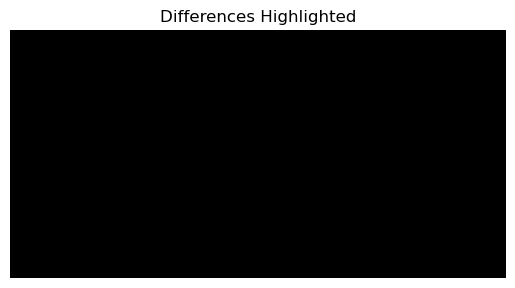

In [49]:
compare_images("sample_docs/degree_image_2.jpg", "sample_docs/degree_image_2.jpg")

Difference score: 111


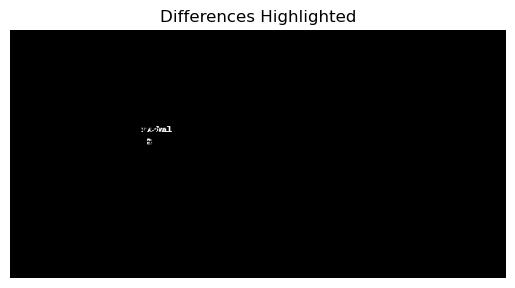

In [51]:
compare_images("sample_docs/degree_image_1.jpg", "sample_docs/degree_image_2.jpg")

In [53]:
def ocr_text_compare(img1_path, img2_path):
    # Extract text using Tesseract OCR
    text1 = pytesseract.image_to_string(Image.open(img1_path))
    text2 = pytesseract.image_to_string(Image.open(img2_path))

    # Display extracted text previews
    print("Text from image 1 (first 300 chars):\n", text1[:300])
    print("\nText from image 2 (first 300 chars):\n", text2[:300])

    # Show line-by-line differences
    print("\n🧾 Differences between image 1 and image 2:")
    diff_lines = list(difflib.unified_diff(
        text1.splitlines(), 
        text2.splitlines(), 
        fromfile='Image 1', 
        tofile='Image 2', 
        lineterm=''
    ))

    if not diff_lines:
        print("No textual differences found.")
    else:
        for line in diff_lines:
            print(line)

In [57]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [59]:
ocr_text_compare("sample_docs/degree_image_1.jpg", "sample_docs/degree_image_2.jpg")

Text from image 1 (first 300 chars):
 certificate of Excellence
Pratyush Kaushal
Issued: 2024


Text from image 2 (first 300 chars):
 certificate of Excellence
Pratyush Kumar
Kssued: 2025


🧾 Differences between image 1 and image 2:
--- Image 1
+++ Image 2
@@ -1,3 +1,3 @@
 certificate of Excellence
-Pratyush Kaushal
-Issued: 2024
+Pratyush Kumar
+Kssued: 2025


In [79]:
# Function to collect /ModDate metadata from PDF files in a folder
def detect_anomalies_smart(meta_list):
    print("Modification Dates Found:", meta_list)
    unique_dates = set(meta_list)

    # 1. Check for duplicate dates
    if len(unique_dates) < len(meta_list):
        print("Warning: Duplicate modification dates detected.")

    # 2. Check for suspiciously far future dates
    now = datetime.now()
    for date_str in meta_list:
        try:
            mod_date = datetime.strptime(date_str[2:], "%Y%m%d%H%M%S")
            days_diff = (mod_date - now).days

            if days_diff > 30:
                print(f"ModDate {date_str} is {days_diff} days in the future!")
            elif days_diff < -365:
                print(f"ModDate {date_str} is very old ({abs(days_diff)} days ago).")
        except Exception as e:
            print(f"Error parsing {date_str}: {e}")
    print("Smart anomaly check complete.")

# Function to detect repeated or inconsistent modification dates
from datetime import datetime

def detect_anomalies_with_date_check(meta_list):
    print("Modification Dates Found:", meta_list)
    unique_dates = set(meta_list)
    if len(unique_dates) < len(meta_list):
        print("Warning: Repeated or inconsistent modification dates detected.")

    # Check for future dates
    now = datetime.now()
    for date_str in meta_list:
        try:
            date_obj = datetime.strptime(date_str[2:], "%Y%m%d%H%M%S")
            if date_obj > now:
                print(f"ModDate {date_str} is in the future!")
        except:
            print(f"Could not parse {date_str}")
    print("Anomaly check complete.")

In [81]:
dates = collect_metadata("sample_docs")
detect_anomalies_smart(dates)

Modification Dates Found: ['D:20240501120000', 'D:20250512130000']
ModDate D:20240501120000 is very old (381 days ago).
Smart anomaly check complete.
